In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

import scipy
import matplotlib.pyplot as plt

import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [7]:
# This section is to test the autoencoder - it generates data that is somewhat similar to the real data

# Test signal generator

# def signal(A, t):
#     return A * np.sin(30*t) * np.exp(-t) + np.random.randn(t.shape[0])/2

In [8]:
# A1 = 3
# t1 = np.linspace(0, 5, 40000)
# s1 = signal(A1, t1)

In [10]:
# def data_generator(n_samples):
#     data = np.empty([n_samples, 40000])
#     for i in range(n_samples):
#         data[i] = signal(A1, t1)

#     return data

# data = data_generator(200)

# # normalise
# data = data / np.max(data)

In [ ]:
# convenience plot function
def plot(x, y, title):
    plt.figure()
    plt.plot(x, y, linewidth=0.7, c='blue')
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()

(46376,)


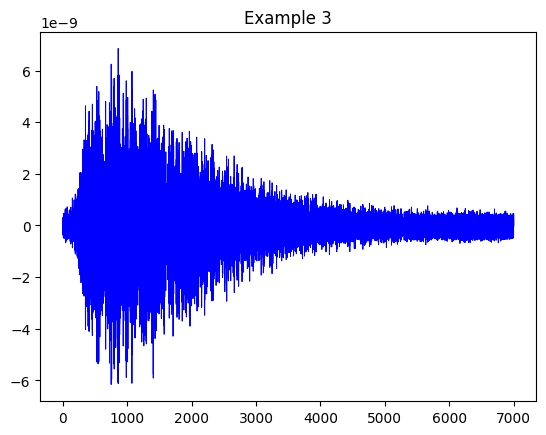

In [32]:
# test_filename = 'xa.s12.00.mhz.1970-03-25HR00_evid00003_trimmed_7000_sec'

data_directory = './'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# plot(tr_times, tr_data, 'Mseed Example')

print(tr_times.shape)

def read_all_mseed_files(data_directory, target_length=None):
    # List all files in the directory with ".mseed" extension
    mseed_files = [f for f in os.listdir(data_directory) if f.endswith('.mseed')]
    
    data_matrix = []
    
    # Loop through all the mseed files and extract time and data series
    for filename in mseed_files:
        st = read(os.path.join(data_directory, filename))
        tr = st.traces[0].copy()  
        tr_data = tr.data  
        
        if target_length is None:
            target_length = len(tr_data)  # Set target length to the first trace's length
        
        # Pad or trim the data to the target length
        if len(tr_data) < target_length:
            # Pad with zeros if shorter
            tr_data = np.pad(tr_data, (0, target_length - len(tr_data)), mode='constant')
        else:
            # Trim if longer
            tr_data = tr_data[:target_length]
        
        data_matrix.append(tr_data)
    
    # Convert the list to a numpy matrix
    data_matrix = np.array(data_matrix)
    
    return data_matrix

data = read_all_mseed_files(data_directory, 46376)

plot(tr_times, data[3], 'Example 3')

In [41]:
# Define the input shape
input_shape = (46376,)

# Build the encoder
def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    encoded = layers.Dense(1024, activation='relu')(inputs)  
    encoded = layers.Dense(512, activation='relu')(encoded)  
    encoded = layers.Dense(128, activation='relu')(encoded)  
    return models.Model(inputs, encoded)

# Build the decoder
def build_decoder():
    encoded_inputs = layers.Input(shape=(128,))
    decoded = layers.Dense(512, activation='relu')(encoded_inputs)
    decoded = layers.Dense(1024, activation='relu')(decoded)
    decoded = layers.Dense(46376, activation='linear')(decoded) 
    return models.Model(encoded_inputs, decoded)

# Build the autoencoder
def build_autoencoder(input_shape):
    encoder = build_encoder(input_shape)
    decoder = build_decoder()
    
    autoencoder_input = layers.Input(shape=input_shape)
    encoded = encoder(autoencoder_input)
    reconstructed = decoder(encoded)
    
    autoencoder = models.Model(autoencoder_input, reconstructed)
    return autoencoder

# Create the autoencoder
autoencoder = build_autoencoder(input_shape)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Display architecture
autoencoder.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 46376)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 128)            │    48,080,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_5 (Functional)       │ (None, 46376)          │    48,126,760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,207,272 (367.00 MB)

 Trainable params: 96,207,272 (367.00 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
autoencoder.fit(data, data, epochs=10, batch_size=10, validation_split=0.2)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 638ms/step - loss: 1.7035e-17 - val_loss: 2.1754e-17
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 609ms/step - loss: 2.0816e-17 - val_loss: 2.1793e-17
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 607ms/step - loss: 1.4756e-17 - val_loss: 2.1855e-17
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 610ms/step - loss: 9.2580e-18 - val_loss: 2.1905e-17
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - loss: 2.1401e-17 - val_loss: 2.1988e-17
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 634ms/step - loss: 1.5923e-17 - val_loss: 2.2044e-17
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 621ms/step - loss: 1.0468e-17 - val_loss: 2.2061e-17
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 631ms/step - loss: 1.0075e-17 - val_loss: 2.2054e-17
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step - loss: 1.5476e-17 - val_loss: 2.2053e-17
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 625ms/step - loss: 1.9096e-17 - val_loss: 2.2073e-17


In [43]:
reconstructed = autoencoder.predict(data)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


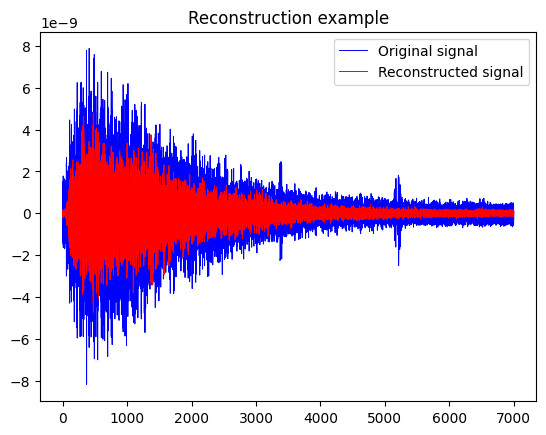

In [44]:
plt.figure()
plt.plot(tr_times, data[0], c='blue', label='Original signal', linewidth=0.7)
plt.plot(tr_times, reconstructed[0], c='red', label='Reconstructed signal', linewidth=0.7)
plt.legend(loc='best')
plt.title('Reconstruction example')
plt.savefig('Reconstruction_ex.png')
plt.show()